# Correlated temperature prediction using LSTM

In cold storage facilities, monitoring the inside temperature is necessary to preserve the products. The larger the ambient is, more sensors are needed to cover all the space. In a cenario where 2 sensors are installed, could we predict one only by measuring the other since they are highly correlated?

This notebook aims to study if it is possible to predict such temperature. We will use a LSTM neural networks due to its capacity of learning temporal behaviours on a time series. 

## Setup and utilities

In [316]:
import scipy as sp
import scipy.stats as ss
import numpy as np
import pandas as pd
import datetime
import pymysql
import mysql.connector
import matplotlib
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
plt.rcParams["figure.figsize"] = (20,5)

In [346]:
def getDataCSV(file):
    
    df = pd.read_csv(file,index_col=1,encoding='cp1252',usecols=['sensor','timestamp', 'value'])
    df.index=pd.to_datetime(df.index)
    return df

def inverse_transform_scale(data):
    
    if isinstance(data,pd.DataFrame):    
        return pd.DataFrame(scaler.inverse_transform(data.values),index=[data.index])
    else:
        return scaler.inverse_transform(data)

def RMSE(x):
    return math.sqrt(training_error.pow(2,axis='columns').mean())
    

Load data from CSV file and plot both temperatures. A resampling is helpful to match both on the same time reference. 

Correlation score between series:  0.9687714408561076


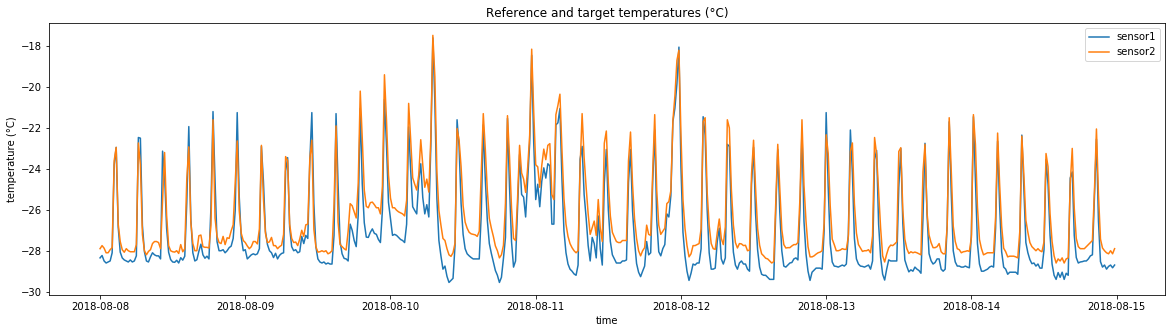

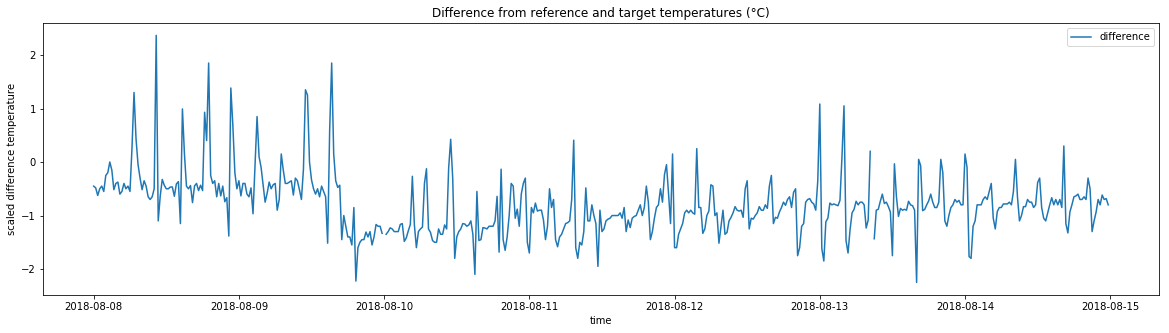

In [353]:
df = getDataCSV('storage_temperature.csv')

#selecting a portion of this data
df = df.loc['2018-8-8 00:00:00':'2018-8-15 00:00:00']

sensors = df.groupby('sensor')

sensor_ref = sensors.get_group('sensor1')['value'].resample('20min').dropna()
sensor_target = sensors.get_group('sensor2')['value'].resample('20min').dropna()

plt.plot(sensor_ref,label='sensor1')
plt.plot(sensor_target,label='sensor2')
plt.title("Reference and target temperatures (°C)")
plt.ylabel('temperature (°C)')
plt.xlabel('time')
plt.legend()

plt.figure()

plt.plot(sensor_ref-sensor_target,label='difference')
plt.title("Difference from reference and target temperatures (°C)")
plt.ylabel('scaled difference temperature')
plt.xlabel('time')
plt.legend()

print("Correlation score between series: ",sensor_ref.corr(sensor_target))

As we suspected, both sensor readins are very correlated, over **0.97** correlation score. Some differences appear due different time sampling, slow dinamics, noise, etc. 

## Data preparation

Here we separate data in "reference" and "target", where "reference" is the data we are going to use to predict the "target". First we scale both series with the same factor to fit them to a range from 0 to 1. The LSTM could not work properly otherwise.

In [354]:
#Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
sensor_ref_index = sensor_ref.index
sensor_ref = scaler.fit_transform(sensor_ref.values.reshape(-1, 1))
sensor_ref = pd.DataFrame(sensor_ref, index=sensor_ref_index)

sensor_target_index = sensor_target.index
sensor_target = scaler.transform(sensor_target.values.reshape(-1, 1))
sensor_target = pd.DataFrame(sensor_target, index=sensor_target_index)


The, we separate the dataset in train data (70%) and test data (30%) and adjust it in a convenient format to train with Keras. Each training instance is composed with the past **k** time samples from "reference" and a target wich is the **t** sample from "target". For k = 3, we'll have  $[X_{t-3},X_{t-2},X_{t-1},X_{t}]$ -> $[Y_t]$

In [355]:
def prepare_dataset(data, target, time_samples=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_samples):
        a = data[i:(i+time_samples), 0]
        dataX.append(a)
        dataY.append(target[i + time_samples-1, 0])
    return np.array(dataX), np.array(dataY)

#using k = 20, the last 20 samples. This covers 400min back. 
time_samples = 20

#70%
break_point = int(len(sensor_ref)*0.7)

trainX, trainY = prepare_dataset(sensor_ref.values[:break_point],sensor_target.values[:break_point], time_samples)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

testX, testY = prepare_dataset(sensor_ref.values[break_point:],sensor_target.values[break_point:],time_samples)
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Modeling and training

For this prediction task we will generate a 2 LSTM layers (one for the input and one hidden) and a single output neuron, which is the prediction on $t$

In [278]:
#Modeling and training
model = Sequential()
model.add(LSTM(50,input_shape=(1,time_samples),return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(output_dim=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
training_history = model.fit(trainX, trainY, epochs=2000, batch_size=32, verbose=2)

Epoch 1/2000
 - 5s - loss: 0.1166
Epoch 2/2000
 - 0s - loss: 0.0750
Epoch 3/2000
 - 0s - loss: 0.0388
Epoch 4/2000
 - 0s - loss: 0.0327
Epoch 5/2000
 - 0s - loss: 0.0282
Epoch 6/2000
 - 0s - loss: 0.0244
Epoch 7/2000
 - 0s - loss: 0.0205
Epoch 8/2000
 - 0s - loss: 0.0189
Epoch 9/2000
 - 0s - loss: 0.0155
Epoch 10/2000
 - 0s - loss: 0.0141
Epoch 11/2000
 - 0s - loss: 0.0139
Epoch 12/2000
 - 0s - loss: 0.0135
Epoch 13/2000
 - 0s - loss: 0.0134
Epoch 14/2000
 - 0s - loss: 0.0139
Epoch 15/2000
 - 0s - loss: 0.0128
Epoch 16/2000
 - 0s - loss: 0.0114
Epoch 17/2000
 - 0s - loss: 0.0114
Epoch 18/2000
 - 0s - loss: 0.0120
Epoch 19/2000
 - 0s - loss: 0.0117
Epoch 20/2000
 - 0s - loss: 0.0112
Epoch 21/2000
 - 0s - loss: 0.0115
Epoch 22/2000
 - 0s - loss: 0.0105
Epoch 23/2000
 - 0s - loss: 0.0104
Epoch 24/2000
 - 0s - loss: 0.0110
Epoch 25/2000
 - 0s - loss: 0.0115
Epoch 26/2000
 - 0s - loss: 0.0104
Epoch 27/2000
 - 0s - loss: 0.0108
Epoch 28/2000
 - 0s - loss: 0.0107
Epoch 29/2000
 - 0s - loss: 0

Epoch 232/2000
 - 0s - loss: 0.0090
Epoch 233/2000
 - 0s - loss: 0.0080
Epoch 234/2000
 - 0s - loss: 0.0083
Epoch 235/2000
 - 0s - loss: 0.0085
Epoch 236/2000
 - 0s - loss: 0.0084
Epoch 237/2000
 - 0s - loss: 0.0079
Epoch 238/2000
 - 0s - loss: 0.0078
Epoch 239/2000
 - 0s - loss: 0.0085
Epoch 240/2000
 - 0s - loss: 0.0083
Epoch 241/2000
 - 0s - loss: 0.0085
Epoch 242/2000
 - 0s - loss: 0.0079
Epoch 243/2000
 - 0s - loss: 0.0079
Epoch 244/2000
 - 0s - loss: 0.0084
Epoch 245/2000
 - 0s - loss: 0.0075
Epoch 246/2000
 - 0s - loss: 0.0081
Epoch 247/2000
 - 0s - loss: 0.0085
Epoch 248/2000
 - 0s - loss: 0.0086
Epoch 249/2000
 - 0s - loss: 0.0083
Epoch 250/2000
 - 0s - loss: 0.0089
Epoch 251/2000
 - 0s - loss: 0.0082
Epoch 252/2000
 - 0s - loss: 0.0084
Epoch 253/2000
 - 0s - loss: 0.0082
Epoch 254/2000
 - 0s - loss: 0.0076
Epoch 255/2000
 - 0s - loss: 0.0075
Epoch 256/2000
 - 0s - loss: 0.0080
Epoch 257/2000
 - 0s - loss: 0.0081
Epoch 258/2000
 - 0s - loss: 0.0079
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 0s - loss: 0.0077
Epoch 461/2000
 - 0s - loss: 0.0081
Epoch 462/2000
 - 0s - loss: 0.0076
Epoch 463/2000
 - 0s - loss: 0.0073
Epoch 464/2000
 - 0s - loss: 0.0081
Epoch 465/2000
 - 0s - loss: 0.0077
Epoch 466/2000
 - 0s - loss: 0.0074
Epoch 467/2000
 - 0s - loss: 0.0074
Epoch 468/2000
 - 0s - loss: 0.0077
Epoch 469/2000
 - 0s - loss: 0.0078
Epoch 470/2000
 - 0s - loss: 0.0075
Epoch 471/2000
 - 0s - loss: 0.0075
Epoch 472/2000
 - 0s - loss: 0.0076
Epoch 473/2000
 - 0s - loss: 0.0078
Epoch 474/2000
 - 0s - loss: 0.0070
Epoch 475/2000
 - 0s - loss: 0.0078
Epoch 476/2000
 - 0s - loss: 0.0076
Epoch 477/2000
 - 0s - loss: 0.0073
Epoch 478/2000
 - 0s - loss: 0.0074
Epoch 479/2000
 - 0s - loss: 0.0075
Epoch 480/2000
 - 0s - loss: 0.0073
Epoch 481/2000
 - 0s - loss: 0.0073
Epoch 482/2000
 - 0s - loss: 0.0074
Epoch 483/2000
 - 0s - loss: 0.0071
Epoch 484/2000
 - 0s - loss: 0.0067
Epoch 485/2000
 - 0s - loss: 0.0078
Epoch 486/2000
 - 0s - loss: 0.0080
Epoch 487/2000
 - 0s - loss:

Epoch 688/2000
 - 0s - loss: 0.0072
Epoch 689/2000
 - 0s - loss: 0.0065
Epoch 690/2000
 - 0s - loss: 0.0072
Epoch 691/2000
 - 0s - loss: 0.0070
Epoch 692/2000
 - 0s - loss: 0.0074
Epoch 693/2000
 - 0s - loss: 0.0072
Epoch 694/2000
 - 0s - loss: 0.0069
Epoch 695/2000
 - 0s - loss: 0.0073
Epoch 696/2000
 - 0s - loss: 0.0070
Epoch 697/2000
 - 0s - loss: 0.0069
Epoch 698/2000
 - 0s - loss: 0.0070
Epoch 699/2000
 - 0s - loss: 0.0071
Epoch 700/2000
 - 0s - loss: 0.0070
Epoch 701/2000
 - 0s - loss: 0.0074
Epoch 702/2000
 - 0s - loss: 0.0075
Epoch 703/2000
 - 0s - loss: 0.0067
Epoch 704/2000
 - 0s - loss: 0.0066
Epoch 705/2000
 - 0s - loss: 0.0067
Epoch 706/2000
 - 0s - loss: 0.0069
Epoch 707/2000
 - 0s - loss: 0.0063
Epoch 708/2000
 - 0s - loss: 0.0074
Epoch 709/2000
 - 0s - loss: 0.0064
Epoch 710/2000
 - 0s - loss: 0.0064
Epoch 711/2000
 - 0s - loss: 0.0073
Epoch 712/2000
 - 0s - loss: 0.0063
Epoch 713/2000
 - 0s - loss: 0.0070
Epoch 714/2000
 - 0s - loss: 0.0068
Epoch 715/2000
 - 0s - loss:

Epoch 916/2000
 - 0s - loss: 0.0063
Epoch 917/2000
 - 0s - loss: 0.0063
Epoch 918/2000
 - 0s - loss: 0.0059
Epoch 919/2000
 - 0s - loss: 0.0066
Epoch 920/2000
 - 0s - loss: 0.0059
Epoch 921/2000
 - 0s - loss: 0.0061
Epoch 922/2000
 - 0s - loss: 0.0062
Epoch 923/2000
 - 0s - loss: 0.0065
Epoch 924/2000
 - 0s - loss: 0.0061
Epoch 925/2000
 - 0s - loss: 0.0063
Epoch 926/2000
 - 0s - loss: 0.0064
Epoch 927/2000
 - 0s - loss: 0.0064
Epoch 928/2000
 - 0s - loss: 0.0062
Epoch 929/2000
 - 0s - loss: 0.0066
Epoch 930/2000
 - 0s - loss: 0.0066
Epoch 931/2000
 - 0s - loss: 0.0068
Epoch 932/2000
 - 0s - loss: 0.0064
Epoch 933/2000
 - 0s - loss: 0.0064
Epoch 934/2000
 - 0s - loss: 0.0065
Epoch 935/2000
 - 0s - loss: 0.0063
Epoch 936/2000
 - 0s - loss: 0.0060
Epoch 937/2000
 - 0s - loss: 0.0057
Epoch 938/2000
 - 0s - loss: 0.0062
Epoch 939/2000
 - 0s - loss: 0.0062
Epoch 940/2000
 - 0s - loss: 0.0060
Epoch 941/2000
 - 0s - loss: 0.0066
Epoch 942/2000
 - 0s - loss: 0.0066
Epoch 943/2000
 - 0s - loss:

Epoch 1140/2000
 - 0s - loss: 0.0055
Epoch 1141/2000
 - 0s - loss: 0.0053
Epoch 1142/2000
 - 0s - loss: 0.0055
Epoch 1143/2000
 - 0s - loss: 0.0059
Epoch 1144/2000
 - 0s - loss: 0.0055
Epoch 1145/2000
 - 0s - loss: 0.0054
Epoch 1146/2000
 - 0s - loss: 0.0058
Epoch 1147/2000
 - 0s - loss: 0.0059
Epoch 1148/2000
 - 0s - loss: 0.0055
Epoch 1149/2000
 - 0s - loss: 0.0053
Epoch 1150/2000
 - 0s - loss: 0.0058
Epoch 1151/2000
 - 0s - loss: 0.0057
Epoch 1152/2000
 - 0s - loss: 0.0054
Epoch 1153/2000
 - 0s - loss: 0.0059
Epoch 1154/2000
 - 0s - loss: 0.0054
Epoch 1155/2000
 - 0s - loss: 0.0053
Epoch 1156/2000
 - 0s - loss: 0.0052
Epoch 1157/2000
 - 0s - loss: 0.0058
Epoch 1158/2000
 - 0s - loss: 0.0060
Epoch 1159/2000
 - 0s - loss: 0.0053
Epoch 1160/2000
 - 0s - loss: 0.0053
Epoch 1161/2000
 - 0s - loss: 0.0059
Epoch 1162/2000
 - 0s - loss: 0.0053
Epoch 1163/2000
 - 0s - loss: 0.0056
Epoch 1164/2000
 - 0s - loss: 0.0050
Epoch 1165/2000
 - 0s - loss: 0.0056
Epoch 1166/2000
 - 0s - loss: 0.0056
E

 - 0s - loss: 0.0045
Epoch 1362/2000
 - 0s - loss: 0.0050
Epoch 1363/2000
 - 0s - loss: 0.0048
Epoch 1364/2000
 - 0s - loss: 0.0049
Epoch 1365/2000
 - 0s - loss: 0.0053
Epoch 1366/2000
 - 0s - loss: 0.0054
Epoch 1367/2000
 - 0s - loss: 0.0055
Epoch 1368/2000
 - 0s - loss: 0.0054
Epoch 1369/2000
 - 0s - loss: 0.0051
Epoch 1370/2000
 - 0s - loss: 0.0041
Epoch 1371/2000
 - 0s - loss: 0.0056
Epoch 1372/2000
 - 0s - loss: 0.0052
Epoch 1373/2000
 - 0s - loss: 0.0041
Epoch 1374/2000
 - 0s - loss: 0.0053
Epoch 1375/2000
 - 0s - loss: 0.0048
Epoch 1376/2000
 - 0s - loss: 0.0042
Epoch 1377/2000
 - 0s - loss: 0.0044
Epoch 1378/2000
 - 0s - loss: 0.0047
Epoch 1379/2000
 - 0s - loss: 0.0053
Epoch 1380/2000
 - 0s - loss: 0.0050
Epoch 1381/2000
 - 0s - loss: 0.0054
Epoch 1382/2000
 - 0s - loss: 0.0050
Epoch 1383/2000
 - 0s - loss: 0.0049
Epoch 1384/2000
 - 0s - loss: 0.0058
Epoch 1385/2000
 - 0s - loss: 0.0049
Epoch 1386/2000
 - 0s - loss: 0.0052
Epoch 1387/2000
 - 0s - loss: 0.0055
Epoch 1388/2000
 

Epoch 1583/2000
 - 0s - loss: 0.0048
Epoch 1584/2000
 - 0s - loss: 0.0047
Epoch 1585/2000
 - 0s - loss: 0.0044
Epoch 1586/2000
 - 0s - loss: 0.0046
Epoch 1587/2000
 - 0s - loss: 0.0047
Epoch 1588/2000
 - 0s - loss: 0.0051
Epoch 1589/2000
 - 0s - loss: 0.0043
Epoch 1590/2000
 - 0s - loss: 0.0052
Epoch 1591/2000
 - 0s - loss: 0.0047
Epoch 1592/2000
 - 0s - loss: 0.0045
Epoch 1593/2000
 - 0s - loss: 0.0047
Epoch 1594/2000
 - 0s - loss: 0.0048
Epoch 1595/2000
 - 0s - loss: 0.0047
Epoch 1596/2000
 - 0s - loss: 0.0052
Epoch 1597/2000
 - 0s - loss: 0.0043
Epoch 1598/2000
 - 0s - loss: 0.0046
Epoch 1599/2000
 - 0s - loss: 0.0049
Epoch 1600/2000
 - 0s - loss: 0.0047
Epoch 1601/2000
 - 0s - loss: 0.0047
Epoch 1602/2000
 - 0s - loss: 0.0049
Epoch 1603/2000
 - 0s - loss: 0.0042
Epoch 1604/2000
 - 0s - loss: 0.0049
Epoch 1605/2000
 - 0s - loss: 0.0055
Epoch 1606/2000
 - 0s - loss: 0.0046
Epoch 1607/2000
 - 0s - loss: 0.0041
Epoch 1608/2000
 - 0s - loss: 0.0045
Epoch 1609/2000
 - 0s - loss: 0.0039
E

 - 0s - loss: 0.0047
Epoch 1805/2000
 - 0s - loss: 0.0044
Epoch 1806/2000
 - 0s - loss: 0.0047
Epoch 1807/2000
 - 0s - loss: 0.0042
Epoch 1808/2000
 - 0s - loss: 0.0042
Epoch 1809/2000
 - 0s - loss: 0.0042
Epoch 1810/2000
 - 0s - loss: 0.0043
Epoch 1811/2000
 - 0s - loss: 0.0044
Epoch 1812/2000
 - 0s - loss: 0.0041
Epoch 1813/2000
 - 0s - loss: 0.0041
Epoch 1814/2000
 - 0s - loss: 0.0041
Epoch 1815/2000
 - 0s - loss: 0.0040
Epoch 1816/2000
 - 0s - loss: 0.0041
Epoch 1817/2000
 - 0s - loss: 0.0033
Epoch 1818/2000
 - 0s - loss: 0.0040
Epoch 1819/2000
 - 0s - loss: 0.0038
Epoch 1820/2000
 - 0s - loss: 0.0038
Epoch 1821/2000
 - 0s - loss: 0.0037
Epoch 1822/2000
 - 0s - loss: 0.0040
Epoch 1823/2000
 - 0s - loss: 0.0035
Epoch 1824/2000
 - 0s - loss: 0.0036
Epoch 1825/2000
 - 0s - loss: 0.0038
Epoch 1826/2000
 - 0s - loss: 0.0044
Epoch 1827/2000
 - 0s - loss: 0.0043
Epoch 1828/2000
 - 0s - loss: 0.0035
Epoch 1829/2000
 - 0s - loss: 0.0036
Epoch 1830/2000
 - 0s - loss: 0.0039
Epoch 1831/2000
 

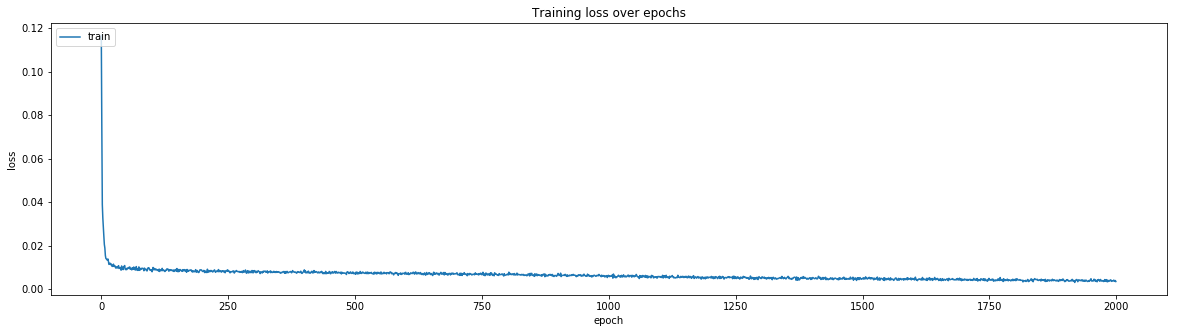

In [356]:
#Training loss curve
plt.plot(training_history.history['loss'])
plt.title('Training loss over epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Evaluation

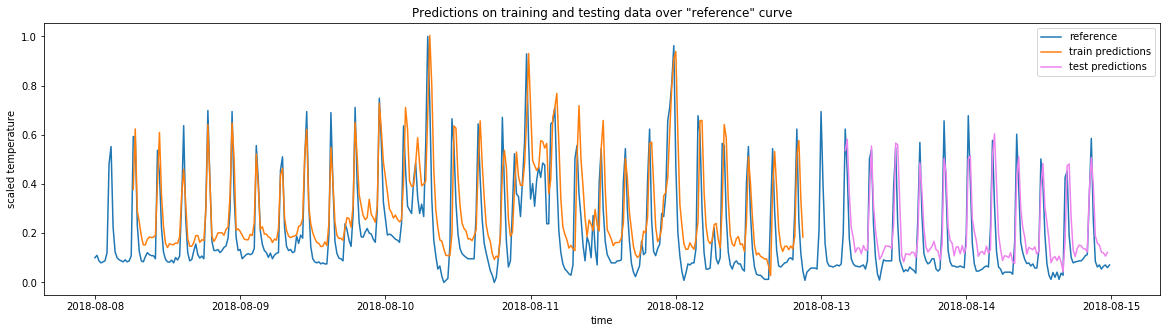

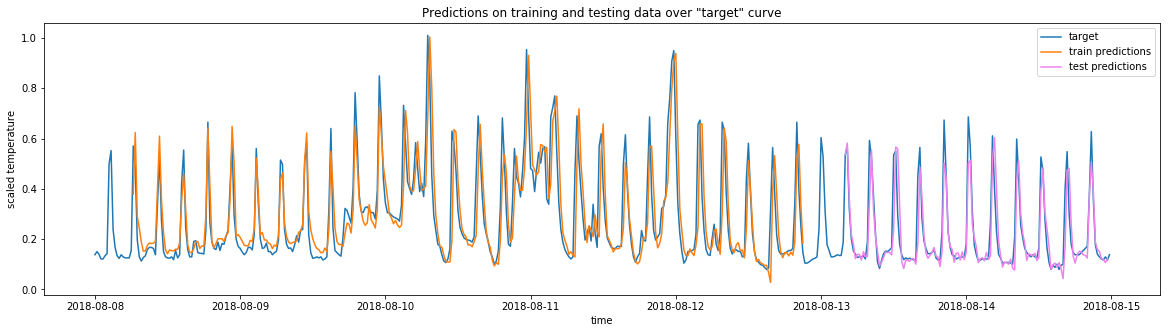

In [357]:
# make predictions
train_predictions = model.predict(trainX)
train_predictions = pd.DataFrame(train_predictions, index=sensor_ref_index[(time_samples-1):break_point-1])

test_predictions = model.predict(testX)
test_predictions = pd.DataFrame(test_predictions, index=sensor_ref_index[break_point+time_samples-1:len(sensor_ref_index)-1])

plt.plot(sensor_ref,label='reference')
plt.plot(train_predictions,label='train predictions')
plt.plot(test_predictions,label='test predictions', color='violet')
plt.title("Predictions on training and testing data over \"reference\" curve")
plt.ylabel('scaled temperature')
plt.xlabel('time')
plt.legend()

plt.figure()

plt.plot(sensor_target,label='target')
plt.plot(train_predictions,label='train predictions')
plt.plot(test_predictions,label='test predictions', color='violet')
plt.title("Predictions on training and testing data over \"target\" curve")
plt.ylabel('scaled temperature')
plt.xlabel('time')
plt.legend()


It seems that the LSTM network was able to learn the beaviour of the target curve. Now we are going to evaluate the error on those predicions:

Train RMSE: 0.05
Test RMSE: 0.08


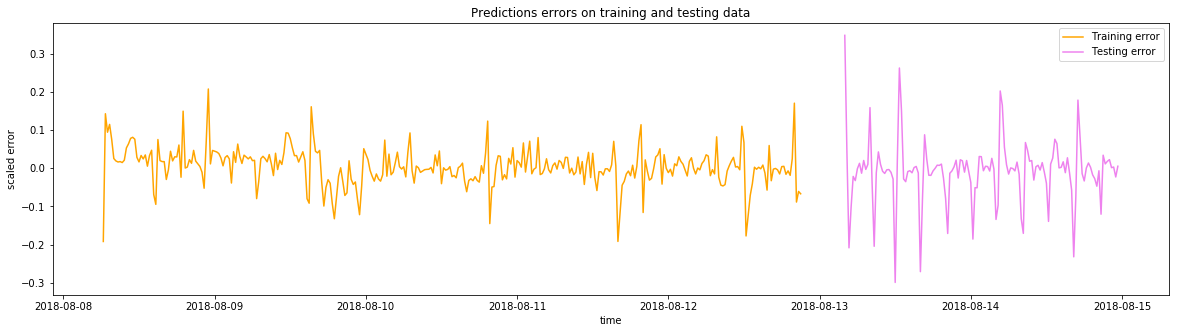

In [358]:
#error evaluation
training_error = train_predictions-trainY.reshape(-1, 1)
testing_error = test_predictions-testY.reshape(-1, 1)

plt.plot(training_error,label='Training error',color='orange')
plt.plot(testing_error,label='Testing error',color='violet')
plt.ylabel('scaled error')
plt.xlabel('time')
plt.legend()
plt.title("Predictions errors on training and testing data")

training_RMSE = math.sqrt(mean_squared_error(trainY, train_predictions.values))
print('Train RMSE: %.2f' % (training_RMSE))
testing_RMSE = math.sqrt(mean_squared_error(testY, test_predictions.values))
print('Test RMSE: %.2f' % (testing_RMSE))

So we have found a relatively low prediction error. But what does that mean in temperature(°C)?

Scaling back to temperature and re-evaluating the error:

Train RMSE: 0.59 (°C)
Test RMSE: 1.00 (°C)


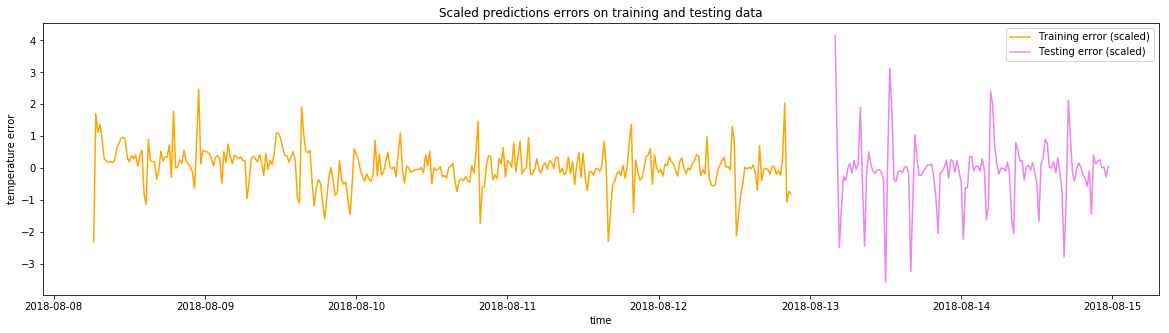

In [359]:
#Scaling back to normal
training_error_rescaled = inverse_transform_scale(train_predictions) - inverse_transform_scale(trainY.reshape(-1, 1))
testing_error_rescaled = inverse_transform_scale(test_predictions) - inverse_transform_scale(testY.reshape(-1, 1))

plt.plot(training_error_rescaled,label='Training error (scaled)',color='orange')
plt.plot(testing_error_rescaled,label='Testing error (scaled)',color='violet')
plt.ylabel('temperature error')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.title("Scaled predictions errors on training and testing data")

training_RMSE = math.sqrt(mean_squared_error(inverse_transform_scale(trainY.reshape(-1, 1)), inverse_transform_scale(train_predictions).values))
testing_RMSE = math.sqrt(mean_squared_error(inverse_transform_scale(testY.reshape(-1, 1)), inverse_transform_scale(test_predictions).values))

print('Train RMSE: %.2f' % (training_RMSE),'(°C)')
print('Test RMSE: %.2f' % (testing_RMSE),'(°C)')


We can also see this errors fitted to a gaussian distribution in order to capture a probabilistic view of the error. 

Train MEAN: 0.05 (°C)
Train STD: 0.59 (°C)
Train MAX: 2.48 (°C)
Train MIN: -2.29 (°C)

Test MEAN: -0.09 (°C)
Test STD: 0.99 (°C)
Test MAX: 4.16 (°C)
Test MIN: -3.57 (°C)


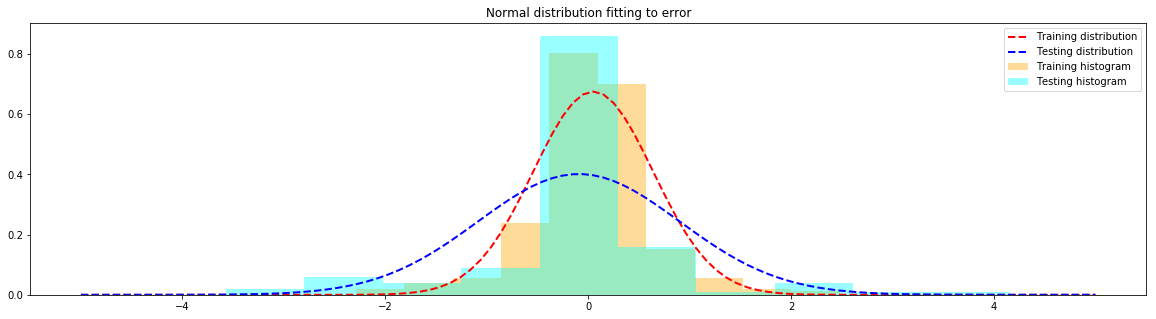

In [360]:
#Fit gaussian distributions to error data
training_mean,training_std = norm.fit(training_error_rescaled)
testing_mean,testing_std = norm.fit(testing_error_rescaled)

x = np.linspace(-5,5,100)
# Generate the pdf (fitted distribution)
training_fitted_pdf = norm.pdf(x,loc = training_mean,scale = training_std)
testing_fitted_pdf = norm.pdf(x,loc = testing_mean,scale = testing_std)

# Type help(plot) for a ton of information on pyplot
plt.plot(x,training_fitted_pdf,"red",label="Training distribution",linestyle="dashed", linewidth=2)
plt.plot(x,testing_fitted_pdf,"blue",label="Testing distribution",linestyle="dashed", linewidth=2)
plt.hist(training_error_rescaled,normed=1,color="orange",alpha=.4,label='Training histogram')
plt.hist(testing_error_rescaled,normed=1,color="cyan",alpha=.4,label='Testing histogram') 
plt.title("Normal distribution fitting to error")
plt.legend()

print('Train MEAN: %.2f' % (sp.mean(training_error_rescaled)),'(°C)')
print('Train STD: %.2f' % (sp.std(training_error_rescaled)),'(°C)')
print('Train MAX: %.2f' % (np.max(training_error_rescaled)),'(°C)')
print('Train MIN: %.2f' % (np.min(training_error_rescaled)),'(°C)')
print("")
print('Test MEAN: %.2f' % (sp.mean(testing_error_rescaled)),'(°C)')
print('Test STD: %.2f' % (sp.std(testing_error_rescaled)),'(°C)')
print('Test MAX: %.2f' % (np.max(testing_error_rescaled)),'(°C)')
print('Test MIN: %.2f' % (np.min(testing_error_rescaled)),'(°C)')

Here we scale back to temperature, like it would happen in production:

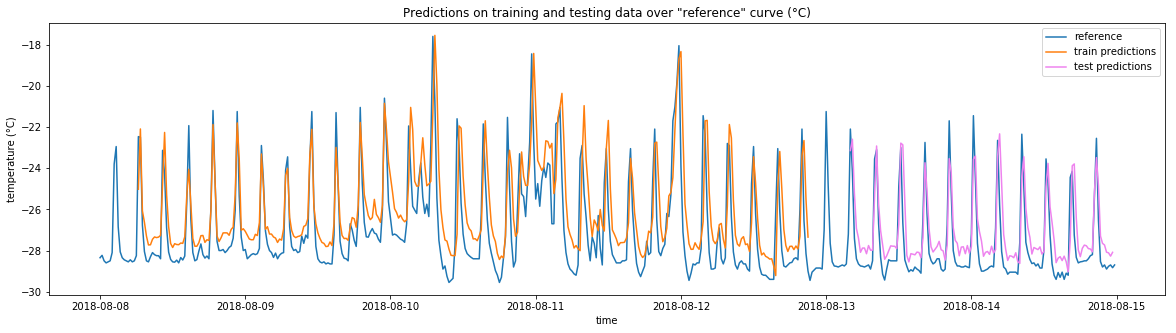

In [361]:
#Scaling back

train_predictions_rescaled = pd.DataFrame(scaler.inverse_transform(train_predictions.values),index=[train_predictions.index])
test_predictions_rescaled = pd.DataFrame(scaler.inverse_transform(test_predictions.values),index=[test_predictions.index])
sensor_rescaled = sensors.get_group('Sensor - [TE-9037] Tunel Congelamento CF21')['Valor'].resample('20min').dropna()

plt.plot(sensor_rescaled,label='reference')
plt.plot(train_predictions_rescaled,label='train predictions')
plt.plot(test_predictions_rescaled,label='test predictions', color='violet')
plt.title("Predictions on training and testing data over \"reference\" curve (°C)")
plt.ylabel('temperature (°C)')
plt.xlabel('time')
plt.legend()

## Conclusion

There is a potential application for this method since the LSTM was able to capture the dinamics and non-linearities of the relation between the reference and target temperatures. Depending on application requirements, the maximum and minimum error found here might be sufficient. This experiment could lead to a removal of the second temperature sensor, or to an expansion of this "virtual sensor" to several others and predict the temperature gradient over a whole storage facility. 

Further work could improve the resuls results from tunning the model and filtering the data. Suggestions and feedbacks are welcome.